# Main analysis

In [1]:
%load_ext autoreload
%load_ext usnm2p.skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime
import itertools

# Internal modules
from usnm2p.logger import logger
from usnm2p.constants import *
from usnm2p.utils import *
from usnm2p.fileops import *
from usnm2p.postpro import *
from usnm2p.plotters import *
from usnm2p.batchutils import *

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
analysis_type = 'main' # DEFAULT_ANALYSIS  # Analysis type
layer = None  # cortical layer
slack_notify = False
global_correction = GLOBAL_CORRECTION  # global stack correction method
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection
errprop = 'inter'
xkeys_plt = [  # Input parameters
    Label.P, 
    Label.DC,
    Label.ISPTA
]

### Derived parameters

In [4]:
# Get batch-related settings
_, input_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, None, layer, global_correction, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'
figs_suffix = f'{figs_suffix}_{errprop}'

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2024/08/07 18:21:20: assembling batch analysis settings...
 2024/08/07 18:21:20: main analysis notebook started on 2024-08-07 at 18:21:20


### Input summary table figure

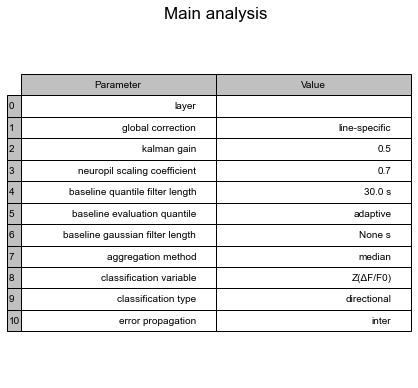

In [5]:
figs['dataset_info'] = plot_table({
    'layer': layer,
    'global correction': 'line-specific' if isinstance(global_correction, dict) else global_correction,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'aggregation method': trial_aggfunc.__name__,
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional",
    'error propagation': errprop,
    }, title='Main analysis', aspect=1.5)

### Load data

In [6]:
stats, counts = load_lineagg_data(input_dir, errprop=errprop)
isall = stats.index.get_level_values(Label.ROI_RESP_TYPE) == 'all'
stats_all = stats[isall].droplevel(Label.ROI_RESP_TYPE)
stats_by_rtype = stats[~isall]
stats_pos = stats_by_rtype.loc[pd.IndexSlice[:, 'positive', :]]

 2024/08/07 18:21:20: loading line-average data (with inter-propagated SE)
 2024/08/07 18:21:20: loading line3 data from /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main folder
 2024/08/07 18:21:20: loading sst data from /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main folder
 2024/08/07 18:21:20: loading pv data from /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/linreg_robust/submap_0<-1_9->10every100/main folder
 2024/08/07 18:21:20: loading sarah_line3 data from /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.

### Plot responder type distribution per mouse line

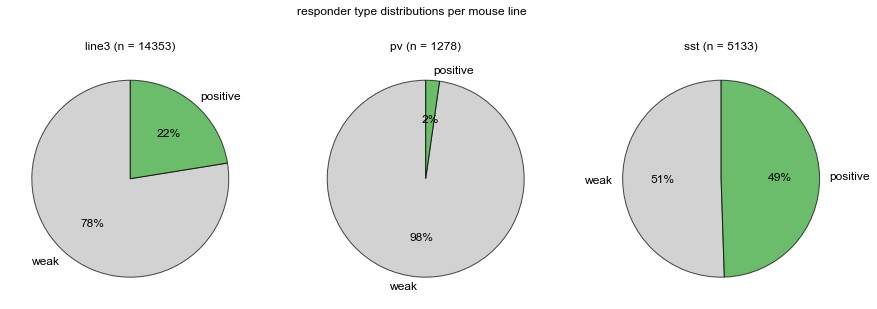

In [7]:
# Plot counts on pie chart
groups = stats_by_rtype.groupby(Label.LINE)
naxes = len(groups)
figs['rtype_dist_per_line'], axes = plt.subplots(1, naxes, figsize=(5 * naxes, 5))
axes = np.atleast_1d(axes)
figs['rtype_dist_per_line'].set_facecolor('w')
figs['rtype_dist_per_line'].suptitle('responder type distributions per mouse line')
for ax, (line, gdata) in zip(axes, groups):
    counts_by_rtype = (gdata['count']
        .groupby(Label.ROI_RESP_TYPE)
        .first()
        .reindex(get_default_rtypes())
        .dropna()
    )
    ax.set_title(f'{line} (n = {counts[line].sum()})')
    counts_by_rtype.plot.pie(
        ax=ax, 
        ylabel='',
        autopct='%1.0f%%',
        colors=[Palette.RTYPE[k] for k in counts_by_rtype.index],
        startangle=90, 
        textprops={'fontsize': 12},
        wedgeprops={'edgecolor': 'k', 'alpha': 0.7}
    )

### Load fits table

In [8]:
fit_dict = get_fit_table()
fit_dict

line,line3,sarah_line3,sst,pv
parameter,,,,
P (MPa),poly2,poly2,poly2,poly2
DC (%),corrected_sigmoid,corrected_sigmoid,corrected_sigmoid_decay,threshold_linear
P_SPTA (MPa),corrected_sigmoid,corrected_sigmoid,corrected_sigmoid_decay,threshold_linear
P_SPTRMS (MPa),corrected_sigmoid,corrected_sigmoid,corrected_sigmoid_decay,threshold_linear
I_SPTA (W/cm2),corrected_sigmoid,corrected_sigmoid,corrected_sigmoid_decay,threshold_linear
I_SPTRMS (W/cm2),corrected_sigmoid,corrected_sigmoid,corrected_sigmoid_decay,threshold_linear


### Plot P and DC dependencies, across lines

 2024/08/07 18:21:21: plotting evoked Z(ΔF/F0) change vs. P (MPa) dependency profile for line3 line
 2024/08/07 18:21:21: fitting order 2 polynomial to data
 2024/08/07 18:21:21: fitting results: popt = [1.7, -0.2, 0.025], R2 = 0.97
 2024/08/07 18:21:21: plotting evoked Z(ΔF/F0) change vs. P (MPa) dependency profile for pv line
 2024/08/07 18:21:21: fitting order 2 polynomial to data
 2024/08/07 18:21:21: fitting results: popt = [-1.3, 1.2, 0.013], R2 = 0.36
 2024/08/07 18:21:21: plotting evoked Z(ΔF/F0) change vs. P (MPa) dependency profile for sst line
 2024/08/07 18:21:21: fitting order 2 polynomial to data
 2024/08/07 18:21:21: fitting results: popt = [2.3, -0.68, 0.059], R2 = 0.98
 2024/08/07 18:21:21: plotting evoked Z(ΔF/F0) change vs. DC (%) dependency profile for line3 line
 2024/08/07 18:21:21: computing fit with sigmoid function: p0 = [33, 40, 1]
 2024/08/07 18:21:21: fitting results: popt = [25, 11, 0.96], R2 = 0.94
 2024/08/07 18:21:21: plotting evoked Z(ΔF/F0) change vs. 

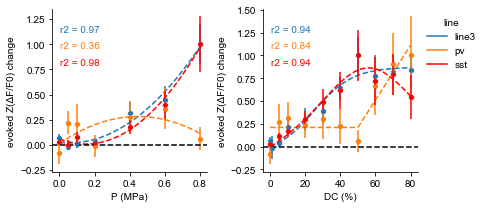

In [9]:
# Define input parameter and associated x-scale
xkeys = [
    Label.P, 
    Label.DC
]

# Define response variables
ykeys = [
    get_change_key(Label.ZSCORE)
]

# # For each response variable
# for ykey in ykeys:
#     # Create figure
#     # figkey = 'simparams_deps'
#     # figs[figkey], axes = plt.subplots(2, 2, figsize=(6, 5))
#     # figs[figkey].suptitle(f'{ykey} - parameter dependency', y=1.02);

#     # With and without fit
#     fits = [None] if ykey == Label.RESP_FRAC else [None, fit_dict]
    # for axrow, fit in zip(axes, fits):

        # # With and without normalization
        # for ax, norm in zip(axrow, [False, True]):
            
# Plot parameter dependency of response variable
fig = plot_parameter_dependency_across_lines(
    stats_all.copy(),
    xkeys,
    ykeys,
    lw=0,
    marker='o',
    err_style='bars',
    fit=fit_dict,
    norm=True
)

# # Add titles to label original and normalized columns
# axes[0, 0].set_title('original')
# axes[0, 1].set_title('normalized')

# # Set aspect ratio to 1 on all axes
# for ax in axes.flat:
#     ax.set_box_aspect(1)

### Plot P - DC alignment for various dose projections, for each mouse line

 2024/08/07 18:21:22: Processing line3 line
 2024/08/07 18:21:22: computing fit with sigmoid function: p0 = [0.27, 0.32, 0.032]
 2024/08/07 18:21:22: fitting results: popt = [0.19, 0.089, 0.031], R2 = 0.93
 2024/08/07 18:21:22: computing fit with sigmoid function: p0 = [6.6, 7.9, 0.032]
 2024/08/07 18:21:22: fitting results: popt = [4.7, 2.2, 0.031], R2 = 0.93
 2024/08/07 18:21:22: computing fit with sigmoid function: p0 = [8.5, 7.7, 0.032]
 2024/08/07 18:21:22: fitting results: popt = [8.7, 1.9, 0.029], R2 = 0.93
 2024/08/07 18:21:23: computing fit with sigmoid function: p0 = [0.27, 0.32, 1.9]
 2024/08/07 18:21:23: fitting results: popt = [0.2, 0.088, 1.8], R2 = 0.94
 2024/08/07 18:21:23: computing fit with sigmoid function: p0 = [6.6, 7.9, 1.9]
 2024/08/07 18:21:23: fitting results: popt = [5, 2.2, 1.8], R2 = 0.94
 2024/08/07 18:21:23: computing fit with sigmoid function: p0 = [8.5, 7.7, 1.9]
 2024/08/07 18:21:23: fitting results: popt = [8.9, 1.8, 1.7], R2 = 0.93
 2024/08/07 18:21:2

/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


 2024/08/07 18:21:26: fitting results: popt = [8.5, 0.48, 0.19, 0.2], R2 = 0.83
 2024/08/07 18:21:26: computing fit with sigmoid_decay function: p0 = [11, 0.12, 0.012, 0.11]
 2024/08/07 18:21:26: fitting results: popt = [12, 0.85, 0.53, 0.17], R2 = 0.84
 2024/08/07 18:21:26: computing fit with sigmoid_decay function: p0 = [0.32, 3.1, 0.31, 6.1]
 2024/08/07 18:21:26: fitting results: popt = [0.44, 8.5, 4.1, 15], R2 = 0.94
 2024/08/07 18:21:26: computing fit with sigmoid_decay function: p0 = [7.9, 0.13, 0.013, 6.1]


/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


 2024/08/07 18:21:26: fitting results: popt = [11, 0.34, 0.17, 15], R2 = 0.94
 2024/08/07 18:21:26: computing fit with sigmoid_decay function: p0 = [11, 0.15, 0.015, 6.1]
 2024/08/07 18:21:26: fitting results: popt = [14, 0.74, 0.47, 11], R2 = 0.94


/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


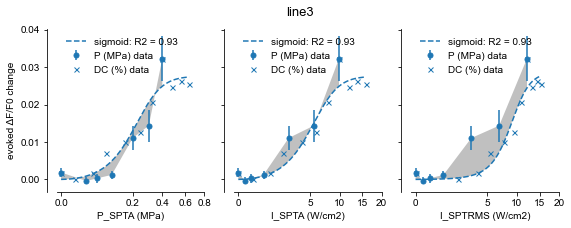

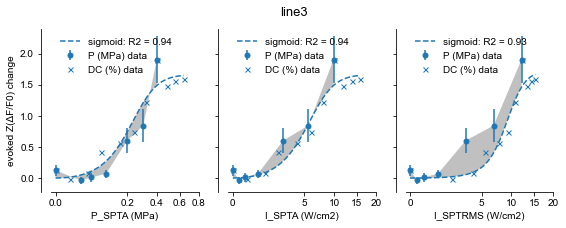

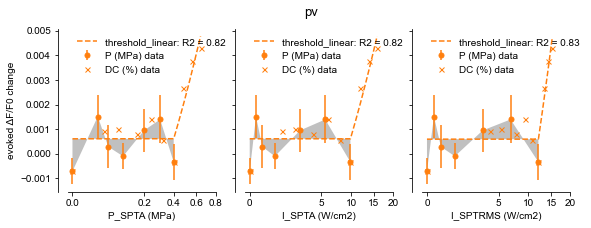

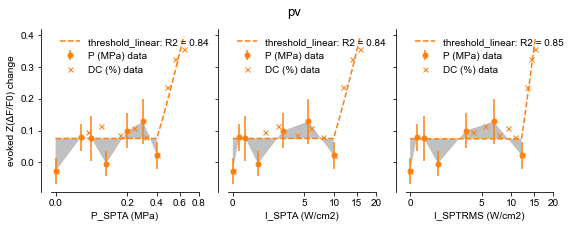

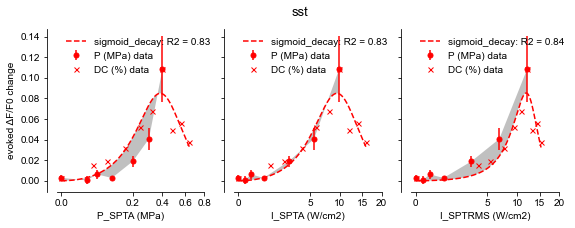

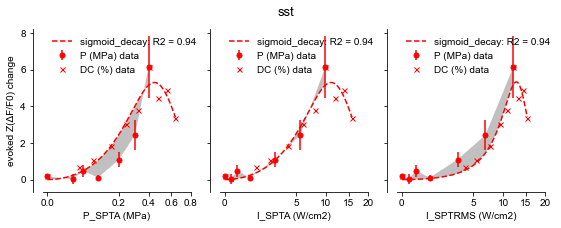

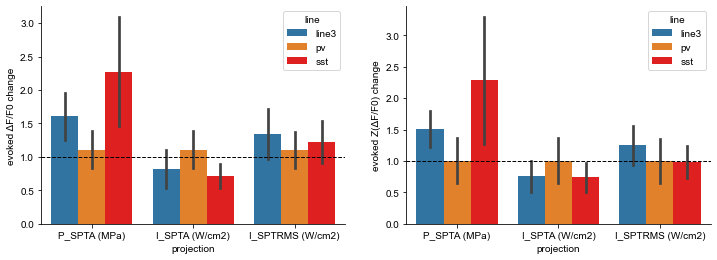

In [10]:
# Dose metrics
xkeys = [
    Label.PSPTA,
    Label.ISPTA,
    Label.ISPTRMS,
]

# Dependent response variables
fit_ykeys = [
    get_change_key(Label.DFF),
    get_change_key(Label.ZSCORE),
]

# Initialize alignment errors dictionary
alignment_errors = []

# For each line
for line, gstats in stats_all.groupby(Label.LINE):
    logger.info(f'Processing {line} line')
    # For each output metrics
    errdists = {}    
    for ykey_diff in fit_ykeys:
        # Evaluate and plot alignment between DC sweep predictor and P sweep data
        figs[f'{line} {ykey_diff} fits'], errdists[ykey_diff] = plot_response_alignment(
            gstats, 
            xkeys, 
            ykey_diff, 
            fit=fit_dict[line], 
            xscale='sqrt', 
            title=line,
            full_output=True
        )
    # Store alignment error distributions
    alignment_errors.append(pd.concat(errdists, axis=1, names=['variable']))

# Concatenate alignment errors
alignment_errors = pd.concat(alignment_errors, axis=0)

# Plot alignment errors distribution for each line, response variable and projection
figs['resp alignment errors'], axes = plt.subplots(1, len(fit_ykeys), figsize=(6 * len(fit_ykeys), 4))
for ax, ykey in zip(axes, fit_ykeys):
    sns.despine(ax=ax)
    sns.barplot(
        ax=ax,
        data=alignment_errors.reset_index(),
        x='projection',
        y=ykey,
        hue=Label.LINE,
        palette=Palette.LINE,
        errorbar='se'
    )
    ax.axhline(1, color='k', linestyle='--', lw=1)

### Plot parameter dependency curves, with fits

 2024/08/07 18:21:28: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 2024/08/07 18:21:28: plotting evoked ΔF/F0 change vs. I_SPTA (W/cm2) dependency profile for line3 line
 2024/08/07 18:21:28: plotting evoked ΔF/F0 change vs. I_SPTA (W/cm2) dependency profile for pv line
 2024/08/07 18:21:28: plotting evoked ΔF/F0 change vs. I_SPTA (W/cm2) dependency profile for sst line
 2024/08/07 18:21:28: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 2024/08/07 18:21:28: plotting evoked ΔF/F0 change vs. I_SPTA (W/cm2) dependency profile for line3 line
 2024/08/07 18:21:28: plotting evoked ΔF/F0 change vs. I_SPTA (W/cm2) dependency profile for pv line
 2024/08/07 18:21:28: plotting evoked ΔF/F0 change vs. I_SPTA (W/cm2) dependency profile for sst line
 2024/08/07 18:21:28: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 2024/08/07 18:21:28: plotting evoked ΔF/F0 change vs. I_SPTA (W/cm2) dependency profile for line3 line
 2024/08/07 18:21:28: computing f

/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


 2024/08/07 18:21:29: fitting results: popt = [9.9, 0.16, 0.0015, 0.16], R2 = 0.77
 2024/08/07 18:21:29: 10% activation threshold for pv line: 0.00 W/cm2
 2024/08/07 18:21:29: plotting evoked ΔF/F0 change vs. I_SPTA (W/cm2) dependency profile for sst line
 2024/08/07 18:21:29: computing fit with sigmoid_decay function: p0 = [7.9, 0.11, 0.011, 1]
 2024/08/07 18:21:29: fitting results: popt = [8.8, 0.49, 0.2, 1.8], R2 = 0.88
 2024/08/07 18:21:29: 10% activation threshold for sst line: 1.63 W/cm2
 2024/08/07 18:21:29: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 2024/08/07 18:21:29: plotting evoked Z(ΔF/F0) change vs. I_SPTA (W/cm2) dependency profile for line3 line
 2024/08/07 18:21:29: plotting evoked Z(ΔF/F0) change vs. I_SPTA (W/cm2) dependency profile for pv line
 2024/08/07 18:21:29: plotting evoked Z(ΔF/F0) change vs. I_SPTA (W/cm2) dependency profile for sst line


/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


 2024/08/07 18:21:29: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 2024/08/07 18:21:29: plotting evoked Z(ΔF/F0) change vs. I_SPTA (W/cm2) dependency profile for line3 line
 2024/08/07 18:21:29: plotting evoked Z(ΔF/F0) change vs. I_SPTA (W/cm2) dependency profile for pv line
 2024/08/07 18:21:29: plotting evoked Z(ΔF/F0) change vs. I_SPTA (W/cm2) dependency profile for sst line
 2024/08/07 18:21:29: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 2024/08/07 18:21:29: plotting evoked Z(ΔF/F0) change vs. I_SPTA (W/cm2) dependency profile for line3 line
 2024/08/07 18:21:29: computing fit with sigmoid function: p0 = [5.1, 7.9, 1.9]
 2024/08/07 18:21:29: fitting results: popt = [3.9, 2.9, 2.1], R2 = 0.94
 2024/08/07 18:21:29: plotting evoked Z(ΔF/F0) change vs. I_SPTA (W/cm2) dependency profile for pv line
 2024/08/07 18:21:29: computing fit with threshold_linear function: p0 = [11, 0.086, 0.016, -0.027]
 2024/08/07 18:21:30: fitting results: popt = [9.9, 0.

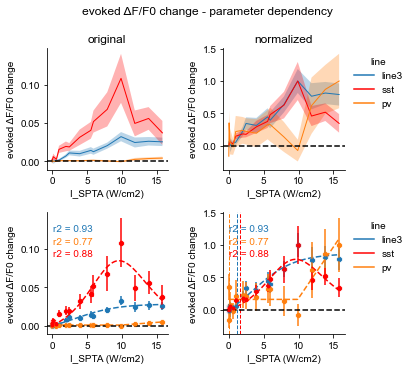

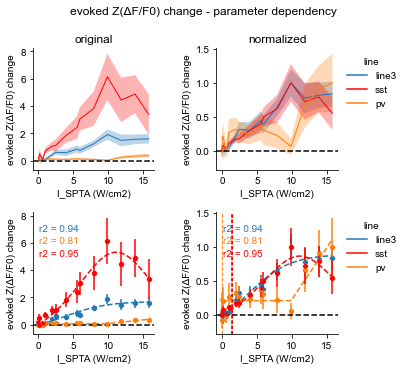

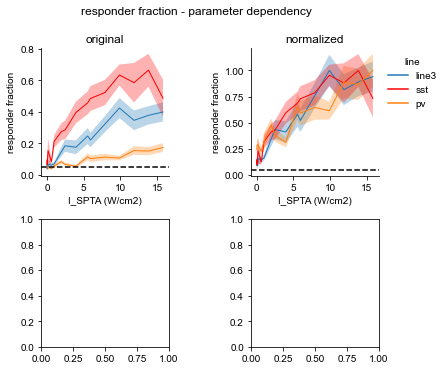

In [11]:
# Define input parameter and associated x-scale
xkey = Label.ISPTA
xscale = None # 'sqrt'  # None

# Define response variables
ykeys = [
    get_change_key(Label.DFF),
    get_change_key(Label.ZSCORE),
    Label.RESP_FRAC
]

# For each response variable
for ykey in ykeys:
    # Create figure
    figkey = f'simparams_deps{ykey}'
    figs[figkey], axes = plt.subplots(2, 2, figsize=(6, 5))
    figs[figkey].suptitle(f'{ykey} - parameter dependency', y=1.02);

    # With and without fit
    fits = [None] if ykey == Label.RESP_FRAC else [None, fit_dict]
    for axrow, fit in zip(axes, fits):

        # With and without normalization
        for ax, norm in zip(axrow, [False, True]):
            
            # Plot parameter dependency of response variable
            plot_parameter_dependency_across_lines(
                stats_all.copy(),
                xkey,
                ykey,
                axes=ax,
                lw=1 if fit is None else 0,
                marker=None if fit is None else 'o',
                err_style='band' if fit is None else 'bars',
                fit=fit,
                legend=norm,
                # fit_ci=0.67,
                norm=norm,
                add_metrics=norm
            )

    # Add titles to label original and normalized columns
    axes[0, 0].set_title('original')
    axes[0, 1].set_title('normalized')
    
    # Set aspect ratio to 1 on all axes
    for ax in axes.flat:
        ax.set_box_aspect(1)

    # Adjust x-scale on all axes, if specified
    if xscale is not None:
        figs[figkey].canvas.draw()
        for ax in axes.flat:
            adjust_xscale(ax, xscale=xscale)

### Inspect pairwise correlations between cell types across ISPTA range

 2024/08/07 18:21:32: extracting aggregate evoked Z(ΔF/F0) change values across I_SPTA (W/cm2) space for each line
 2024/08/07 18:21:32: ISPTA bifurcation point: 9.89 W/cm2
 2024/08/07 18:21:32: deriving I_SPTA (W/cm2) response scaling predictor function for line3 line
 2024/08/07 18:21:32: computing fit with sigmoid function: p0 = [5.4, 7.9, 1.9]
 2024/08/07 18:21:32: fitting results: popt = [3.9, 2.9, 2.2], R2 = 0.94
 2024/08/07 18:21:32: deriving I_SPTA (W/cm2) response scaling predictor function for pv line
 2024/08/07 18:21:32: computing fit with threshold_linear function: p0 = [11, 0.086, 0.016, -0.027]
 2024/08/07 18:21:33: fitting results: popt = [9.9, 0.054, 0.00033, 0.075], R2 = 0.81
 2024/08/07 18:21:33: deriving I_SPTA (W/cm2) response scaling predictor function for sst line
 2024/08/07 18:21:33: computing fit with sigmoid_decay function: p0 = [7.9, 0.11, 0.011, 6.1]
 2024/08/07 18:21:33: fitting results: popt = [11, 0.36, 0.17, 14], R2 = 0.95
 2024/08/07 18:21:33: plotting

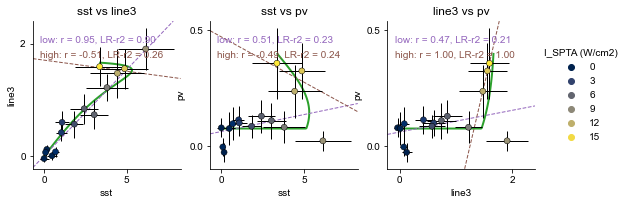

In [12]:
# Define variable of interest
ykey = Label.ZSCORE
ykey_diff = get_change_key(ykey)
mu_key, sem_key = get_propagg_keys(ykey_diff)

# Extract aggregate responses across ISPTA space for each line
logger.info(f'extracting aggregate {ykey_diff} values across {Label.ISPTA} space for each line')
resps_vs_ISPTA = (
    stats_all[[Label.ISPTA, mu_key, sem_key]]  # Extract ISPTA, mean and SEM
    .droplevel(Label.RUN)  # Drop run level
    .set_index(Label.ISPTA, append=True)  # Set ISPTA as index
    .sort_index()  # Sort index
    .unstack(level=Label.LINE)  # Unstack cell types to columns
    .dropna(axis=0, how='any')  # Remove lines with missing data
)

# # Normalize response vectors
# logger.info('normalizing response vectors')
# amax_resps = resps_vs_ISPTA[mu_key].abs().max()
# for k in resps_vs_ISPTA.columns.levels[0]:
#     resps_vs_ISPTA[k] /= amax_resps

# Extract ISPTA "phenomenological bifurcation point" and split data accordingly
Ispta_bif = (stats_all
    [(stats_all[Label.P] == P_REF) & (stats_all[Label.DC] == DC_REF)]
    [Label.ISPTA]
    .unique()
    [0]
) 
logger.info(f'ISPTA bifurcation point: {Ispta_bif:.2f} W/cm2')
resps_vs_ISPTA_split = {
    'low': resps_vs_ISPTA[resps_vs_ISPTA.index < Ispta_bif],
    'high': resps_vs_ISPTA[resps_vs_ISPTA.index > Ispta_bif]
}
split_cdict = {'low': 'C4', 'high': 'C5'}

# Compute response vs. ISPTA scaling predictors for each line
pred_funcs = {}
for line in resps_vs_ISPTA[mu_key]:
    logger.info(f'deriving {Label.ISPTA} response scaling predictor function for {line} line')
    pred_funcs[line] = compute_predictor(
        resps_vs_ISPTA.index.values, resps_vs_ISPTA[mu_key][line].values, fit_dict.loc[Label.ISPTA, line])

# Define lines and their combination pairs
lines = ['sst', 'line3', 'pv']
pairs = list(itertools.combinations(lines, 2))

# Define dense ISPTA space   
ISPTA_dense = np.linspace(resps_vs_ISPTA.index.min(), resps_vs_ISPTA.index.max(), 100)

# Plot pairwise distributions
logger.info('plotting pairwise distributions')
figs['pariwise correlations between lines'], axes = plt.subplots(
        1, len(pairs), figsize=(3 * len(pairs), 3))
# For each pair of lines
for iax, (ax, (line1, line2)) in enumerate(zip(axes, pairs)):
    label = f'{line1} vs {line2}'

    # Set axis layout
    sns.despine(ax=ax)
    ax.set_title(label)
    ax.set_box_aspect(1)

    # Plot pairwise distribution 
    sns.scatterplot(
        data=resps_vs_ISPTA[mu_key].reset_index(),
        x=line1,
        y=line2,
        ax=ax,
        hue=Label.ISPTA,
        palette='cividis',
        legend=True if iax == len(pairs) - 1 else False,
        ec='k',
    )

    # Plot fits co-variation
    fit_covar_traj = np.array([pred_funcs[line1](ISPTA_dense), pred_funcs[line2](ISPTA_dense)]).T
    ax.plot(
        *fit_covar_traj.T,
        c='C2', 
        lw=2,
        zorder=-2
    )

    # Extract mean values and error bars
    mu_data, sem_data = resps_vs_ISPTA[mu_key], resps_vs_ISPTA[sem_key]

    # Add x and y error bars
    ax.errorbar(
        mu_data[line1],
        mu_data[line2],
        xerr=sem_data[line1],
        yerr=sem_data[line2],
        fmt='none',
        color='k',
        lw=1,
        zorder=0,
    )

    ytxt = 0.9

    # For each side of the bifurcation point
    for side, gdata in resps_vs_ISPTA_split.items():
        mu_data = gdata[mu_key]
        color = split_cdict[side]

        # Compute correlation coefficient between line2 and line1
        r = mu_data[[line1, line2]].corr().iloc[0, 1]

        # Perform robust linear regression of line2 on line1
        regres, regmodel = mylinregress(mu_data[line1], mu_data[line2], robust=True, return_model=True)
        xreg = np.array([mu_data[line1].min(), mu_data[line1].max()])
        ax.axline(
            *zip(xreg, regres.intercept + regres.slope * xreg), 
            color=color, linestyle='--', lw=1, zorder=-1)

        # Compute regression metrics
        ypred = regres.intercept + regres.slope * mu_data[line1]
        r2 = rsquared(mu_data[line2], ypred)

        # Annotate with correlation coefficient and regression fit
        ax.text(
            0.05, ytxt, f'{side}: r = {r:.2f}, LR-r2 = {r2:.2f}', 
            color=color, ha='left', va='top', transform=ax.transAxes)        
        ytxt -= 0.1

    # Set number of ticks to 2 on both axes
    ax.locator_params(axis='both', nbins=2)

# Move legend to the right of rightmost axis
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5), title=Label.ISPTA, frameon=False)

### Plot average cell density per line

 2024/08/07 18:21:33: computing cell densities from cell counts
 2024/08/07 18:21:33: plotting cell densities across lines


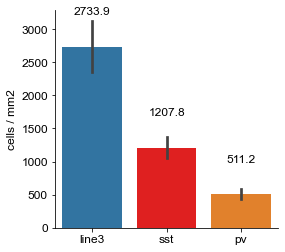

In [13]:
# Compute cell densities from cell counts
logger.info('computing cell densities from cell counts')
Lx = Ly = .5  # FOV dimensions (mm)
fov_area = Lx * Ly  # mm2
densities = (counts / fov_area).rename(Label.ROI_DENSITY)

# Plot average cell densities
logger.info('plotting cell densities across lines')
fs = 12
figs['cell densities'], ax = plt.subplots(figsize=(4, 4))
sns.despine(ax=ax)
sns.barplot(
    data=densities.reset_index(), 
    ax=ax, 
    x=Label.LINE, 
    y=Label.ROI_DENSITY,
    palette=Palette.LINE,
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', fontsize=fs, padding=30)
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(fs)
ax.set_xlabel(None)
ax.set_ylabel(Label.ROI_DENSITY, fontsize=fs);

### Define E/I roles and factors for each cell type in the circuit

In [14]:
cellstats = densities.groupby(Label.LINE).mean().to_frame()
logger.info('computing cell line statistics')
cellstats['factor'] = cellstats[Label.ROI_DENSITY] / cellstats[Label.ROI_DENSITY].max()
cellstats['type'] = {
    'line3': 'E',
    'sst': 'I',
    'pv': 'I',
}
cellstats['sign'] = cellstats['type'].map({'E': 1, 'I': -1})
cellstats['prefix'] = cellstats['type'].map({'E': '+', 'I': '-'})
cellstats

 2024/08/07 18:21:33: computing cell line statistics


,cells / mm2,factor,type,sign,prefix
line,,,,,
line3,2733.904762,1.000000,E,1,+
pv,511.200000,0.186985,I,-1,-
sst,1207.764706,0.441773,I,-1,-


### Plot nominal and scaled responses per mouse line, and net circuit effect

In [15]:
# cellstats['factor'] = {
#     'line3': .75,
#     'sst': 0.075,
#     'pv': 0.1,
# }

 2024/08/07 18:21:34: extracting, computing, and scaling line3 responses
 2024/08/07 18:21:34: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 2024/08/07 18:21:34: computing fit with sigmoid function: p0 = [5.1, 7.9, 0.032]
 2024/08/07 18:21:34: fitting results: popt = [3.4, 3, 0.037], R2 = 0.93
 2024/08/07 18:21:34: extracting, computing, and scaling pv responses
 2024/08/07 18:21:34: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 2024/08/07 18:21:34: computing fit with threshold_linear function: p0 = [12, 0.0012, 0.016, -0.00071]
 2024/08/07 18:21:34: fitting results: popt = [9.9, 0.00069, 0.0021, 0.00069], R2 = 0.77
 2024/08/07 18:21:34: extracting, computing, and scaling sst responses
 2024/08/07 18:21:34: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 2024/08/07 18:21:34: computing fit with sigmoid_decay function: p0 = [7.9, 0.13, 0.013, 0.11]
 2024/08/07 18:21:34: fitting results: popt = [8.8, 0.49, 0.2, 0.19], R2 = 0.88
 2024/08/07 18:

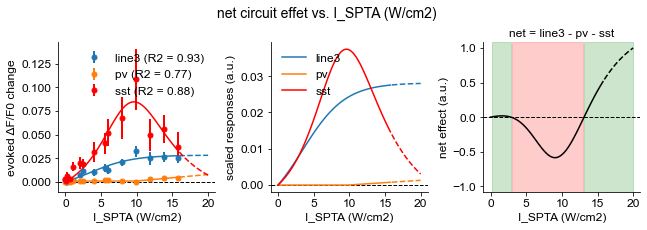

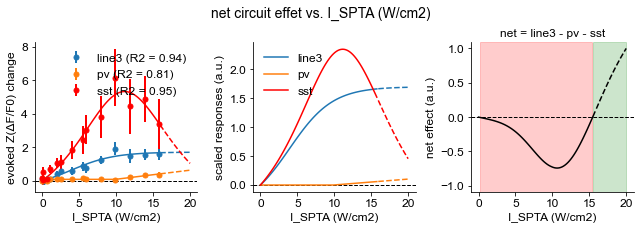

In [16]:
# Input parameter and its max value
xkey = Label.ISPTA
xmax = 20.

# Dependent response variables
ykeys = [
    get_change_key(Label.DFF), 
    get_change_key(Label.ZSCORE)
]

# For each response variable, plot circuit effect
for ykey in ykeys:
    figs[f'net_effect_{ykey}'] = plot_circuit_effect(
        stats_all, 
        cellstats, 
        xkey, 
        ykey, 
        # ci=.67,
        xmax=xmax,
        fit=fit_dict,
        add_net_color=True,
    )

### Save figures

In [17]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 2024/08/07 18:21:35: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2024.08.07/figs_main_all_line-specific_k0.5_alpha0.7_qadaptive_wq30.0s_aggmedian_classzscore_directional_inter.pdf:


100%|██████████| 16/16 [00:02<00:00,  5.48it/s]


### Notify upon completion

In [18]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'main analysis notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2024/08/07 18:21:39: main analysis notebook completed in 0:00:18.744124 s
